# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.transform import TrimAfterTrigger, apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  4000


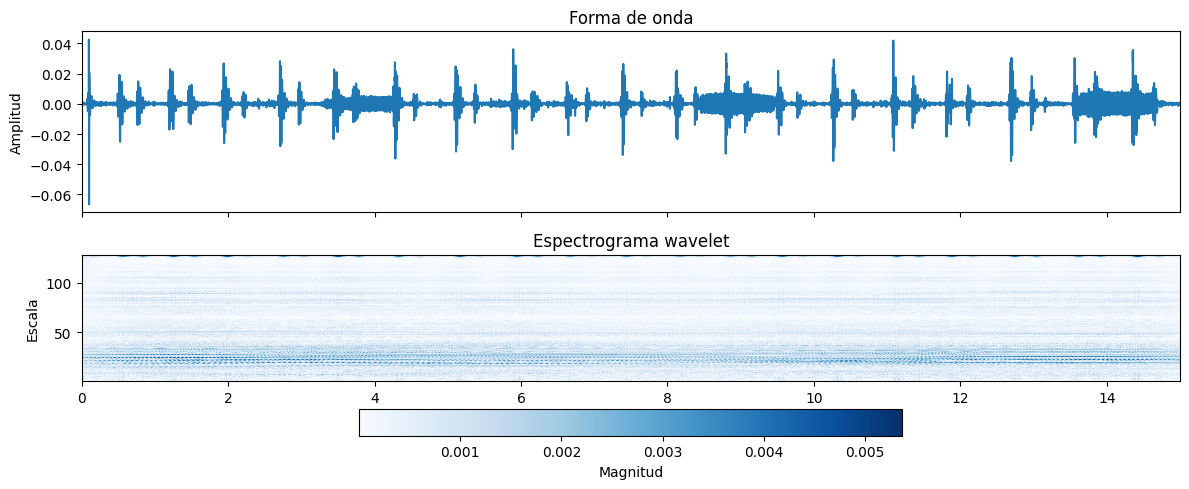

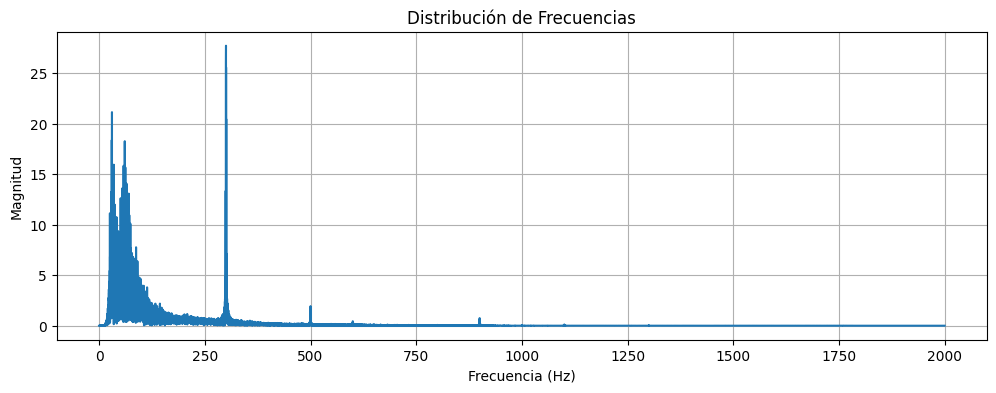

In [2]:
AUDIO_NAME = "test-202407211616.wav"
DIGITAL_AUDIO_DIR = get_base_dir().joinpath(f"data/digital/{AUDIO_NAME}")

digital_audio, sample_rate = torchaudio.load(str(DIGITAL_AUDIO_DIR))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(digital_audio.numpy(), sample_rate)
plot_audio_fft(digital_audio.numpy(), sample_rate)

Audio(digital_audio, rate=sample_rate, autoplay=True)

# Focus on synthetic frequency

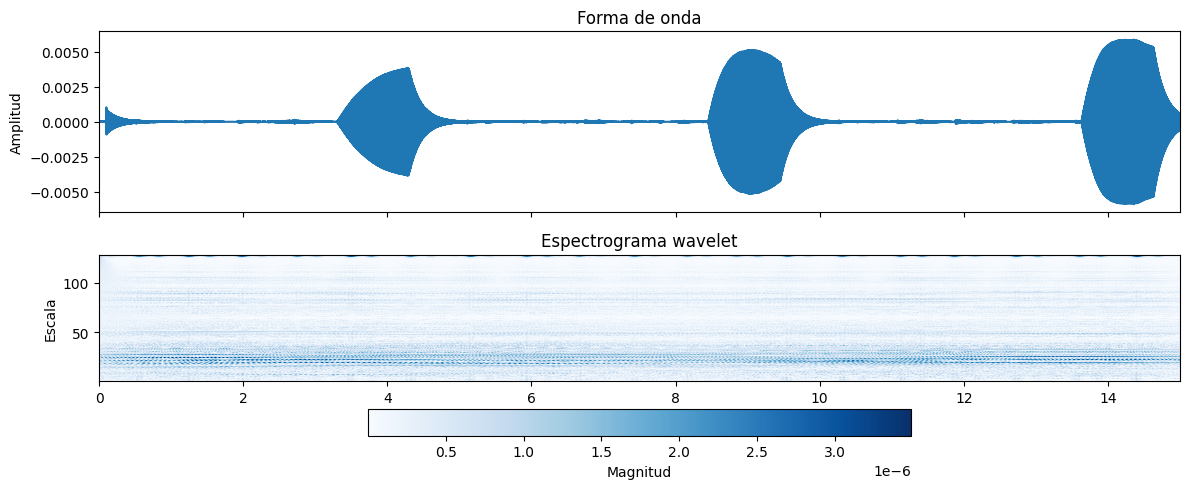

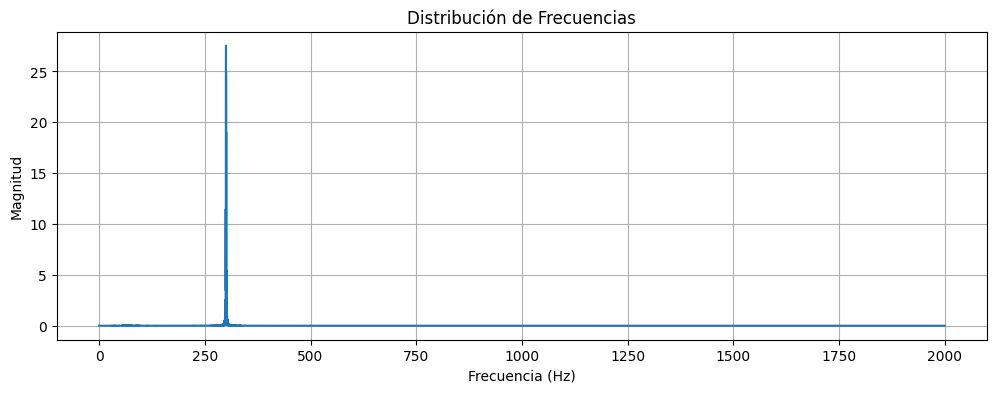

In [3]:
SYNTHETIC_FREQ = 300
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(
    digital_audio, sample_rate, low_cutoff, high_cutoff
)

plot_wavelet_spectrogram(filtered_audio.numpy(), sample_rate)
plot_audio_fft(filtered_audio.numpy(), sample_rate)

Audio(filtered_audio, rate=sample_rate, autoplay=True)

# Downsample and smooth it

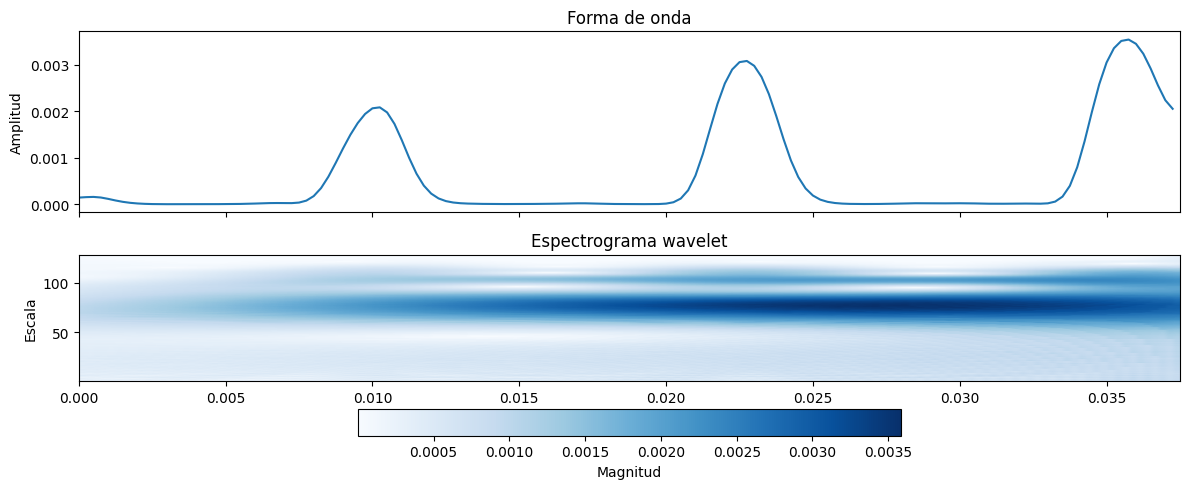

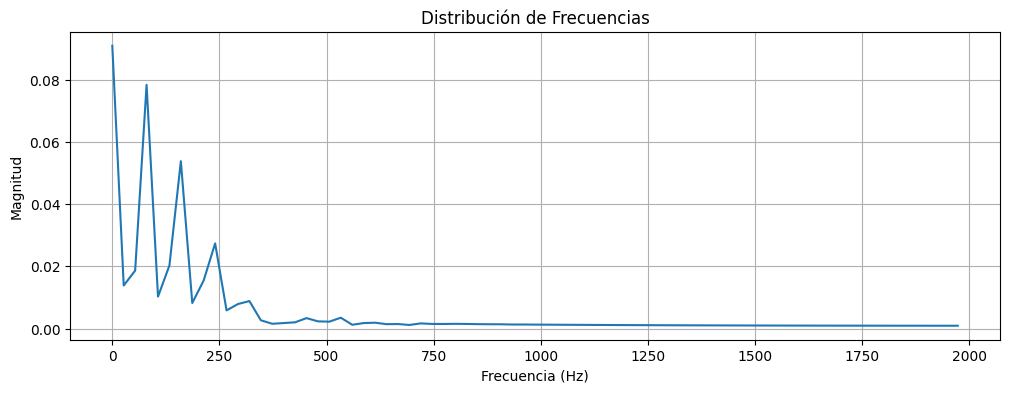

In [4]:
tat = TrimAfterTrigger()
DOWNSAMPLE_FACTOR = 400
SIGMA_SMOOTH = 2

smoothed = tat.abs_downsample_smooth(filtered_audio, DOWNSAMPLE_FACTOR, SIGMA_SMOOTH)
plot_wavelet_spectrogram(smoothed, sample_rate, downsample_factor=1)
plot_audio_fft(smoothed, sample_rate)

Audio(smoothed, rate=sample_rate / DOWNSAMPLE_FACTOR, autoplay=True)

# Find peaks where signal changes

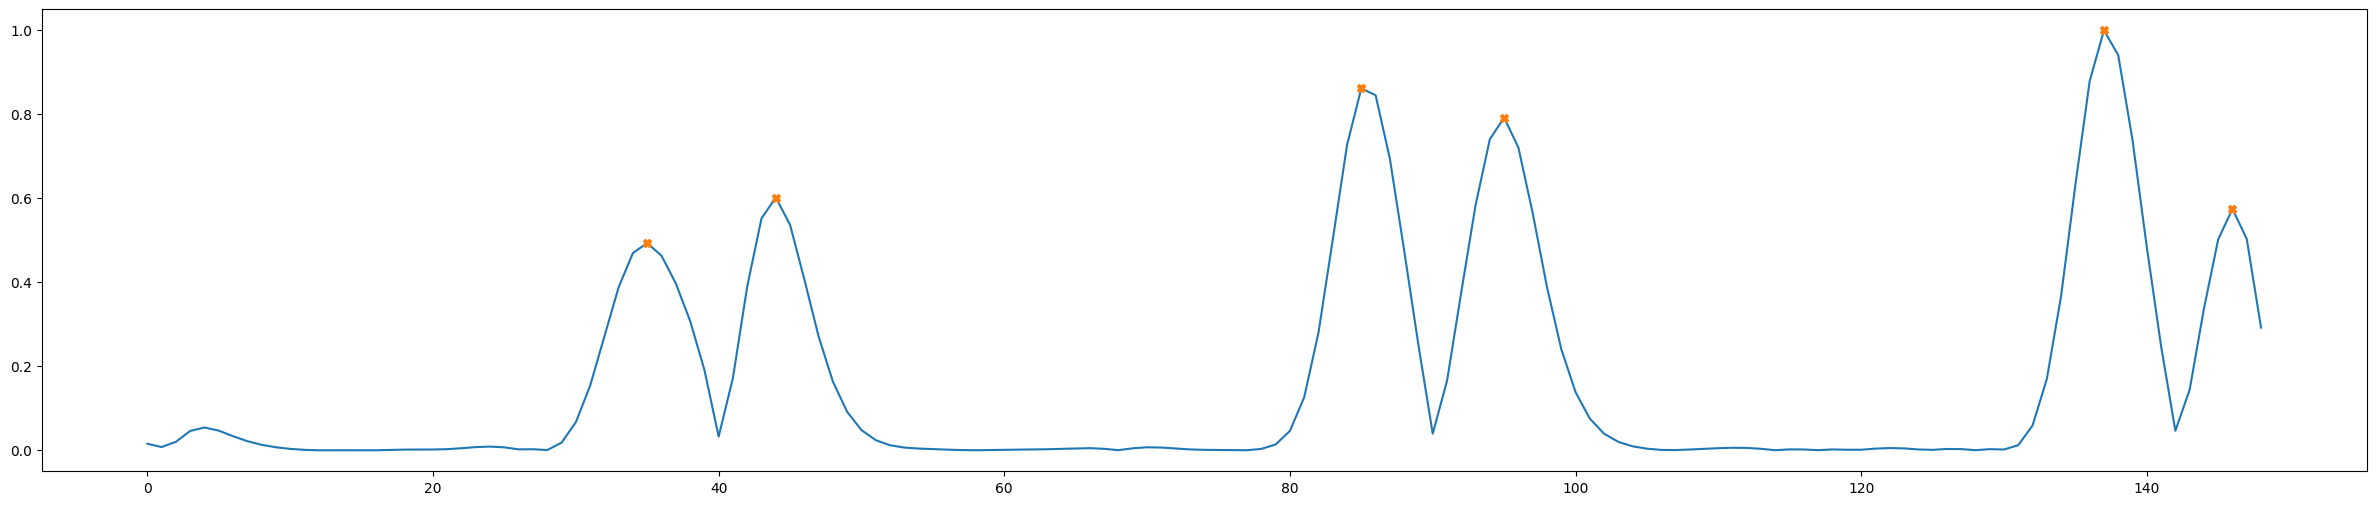

In [5]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(30, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

# Upsample those peaks in the raw audio signal

Peaks found in downsampled signal: [ 35  44  85  95 137 146]
Peaks in real signal: [14000 17600 34000 38000 54800 58400]


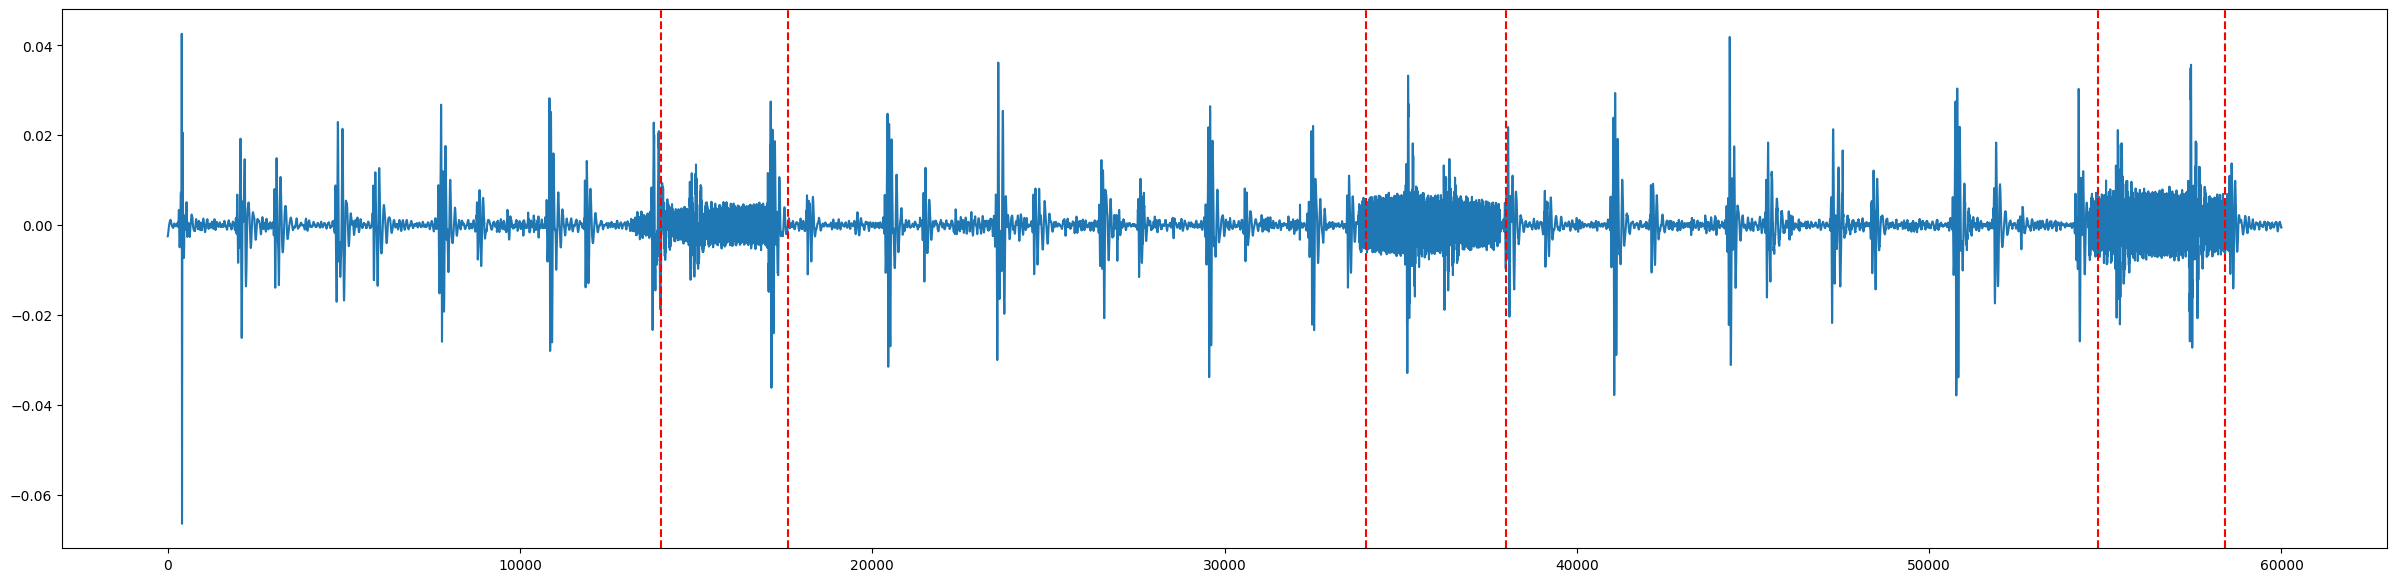

In [6]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(digital_audio.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color='red', linestyle='--')

plt.show()

# Adjust peaks to make sure the trigger is considered

In [7]:
print(f"Peaks: {upsampled_peaks}")

segment_duration = np.diff(upsampled_peaks) / sample_rate
print(f"Duration (without the first one): {segment_duration}")

is_peak_start = np.concatenate([segment_duration < 2, [False]])
is_peak_end = np.concatenate([[False], segment_duration < 2])

peak_starts = upsampled_peaks[is_peak_start]
peak_ends = upsampled_peaks[is_peak_end]

print(f"Peak starts on: {peak_starts}")
print(f"Peak ends on: {peak_ends}")

Peaks: [14000 17600 34000 38000 54800 58400]
Duration (without the first one): [0.9 4.1 1.  4.2 0.9]
Peak starts on: [14000 34000 54800]
Peak ends on: [17600 38000 58400]


In [8]:
TRIGGER_DURATION = 1
duration_adj = TRIGGER_DURATION + 0.1

trigger_starts = []
trigger_ends = []

for start, end in zip(peak_starts, peak_ends):
    raw_duration = (end - start) / sample_rate
    duration_diff = duration_adj - raw_duration
    half_diff = duration_diff / 2

    to_adjust = half_diff * sample_rate

    trigger_starts.append(start - to_adjust)
    trigger_ends.append(end + to_adjust)

print(f"Trigger starts on: {trigger_starts}")
print(f"Trigger ends on: {trigger_ends}")

new_duration = [(end - start) / sample_rate for start, end in zip(trigger_starts, trigger_ends)]
print(f"With duration adjusted to: {new_duration}")

Trigger starts on: [13600.0, 33800.0, 54400.0]
Trigger ends on: [18000.0, 38200.0, 58800.0]
With duration adjusted to: [1.1, 1.1, 1.1]


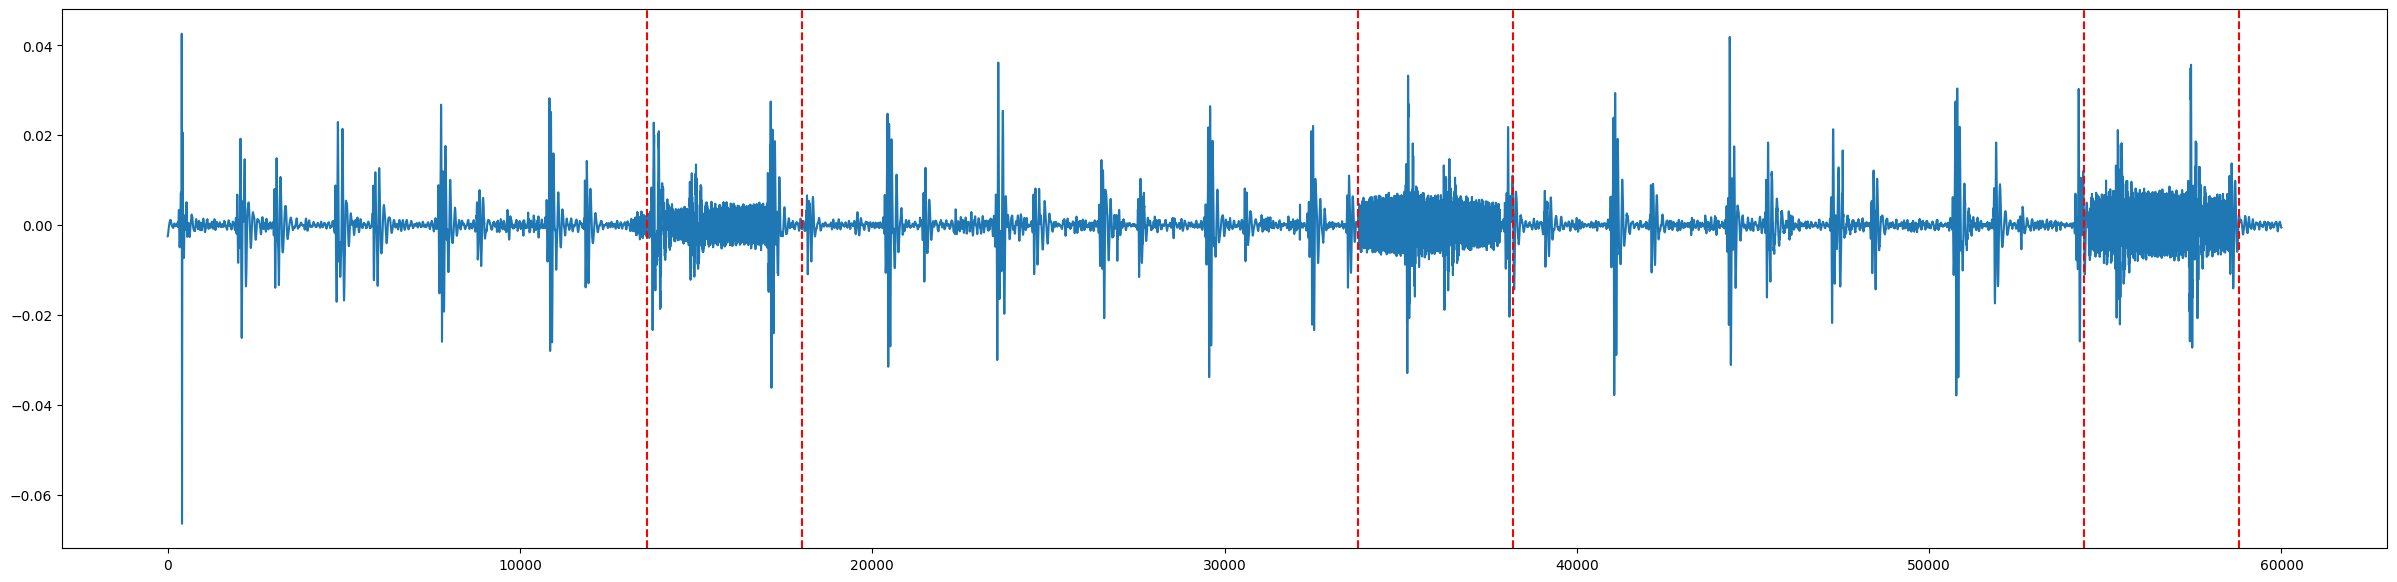

In [9]:
plt.figure(figsize=(30, 7))
plt.plot(digital_audio.squeeze())

for start, end in zip(trigger_starts, trigger_ends):
    plt.axvline(x=start, color='red', linestyle='--')
    plt.axvline(x=end, color='red', linestyle='--')

plt.show()

# Split signal

In [10]:
new_peaks = np.array(sorted(trigger_starts + trigger_ends)).astype(int)
new_peaks

array([13600, 18000, 33800, 38200, 54400, 58800])

In [11]:
split_points = np.concatenate(([0], new_peaks, [digital_audio.shape[1]]))

audio_tensor = digital_audio.squeeze()
segments = [
    audio_tensor[split_points[i] : split_points[i + 1]]
    for i in range(len(split_points) - 1)
]

for i, segment in enumerate(segments):
    duration = len(segment) / sample_rate
    to_print = f"#{i+1} ({duration:.2f}s)"

    if duration == duration_adj:
        to_print += " trigger"
    else:
        to_print += " segment"

    to_print += f": {segment}"
    print(to_print)

#1 (3.40s) segment: tensor([-0.0025, -0.0025, -0.0025,  ...,  0.0005, -0.0004, -0.0014])
#2 (1.10s) trigger: tensor([-0.0020, -0.0022, -0.0020,  ..., -0.0009, -0.0009, -0.0008])
#3 (3.95s) segment: tensor([-0.0008, -0.0008, -0.0008,  ...,  0.0013,  0.0012,  0.0011])
#4 (1.10s) trigger: tensor([ 0.0014,  0.0019,  0.0021,  ..., -0.0018, -0.0027, -0.0035])
#5 (4.05s) segment: tensor([-0.0044, -0.0053, -0.0062,  ..., -0.0041, -0.0048, -0.0055])
#6 (1.10s) trigger: tensor([-0.0061, -0.0067, -0.0073,  ...,  0.0022,  0.0022,  0.0022])
#7 (0.30s) segment: tensor([ 0.0022,  0.0021,  0.0021,  ..., -0.0005, -0.0005, -0.0005])


# Keep just the valid segments

#1 (3.4s): tensor([-0.0025, -0.0025, -0.0025,  ...,  0.0005, -0.0004, -0.0014])


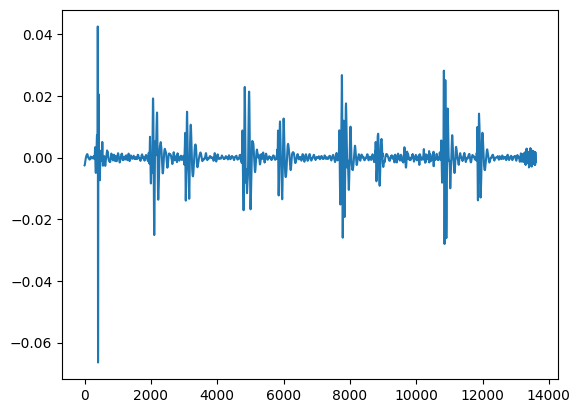

#2 (3.95s): tensor([-0.0008, -0.0008, -0.0008,  ...,  0.0013,  0.0012,  0.0011])


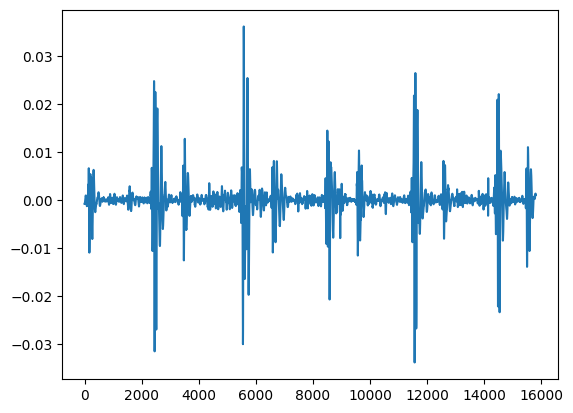

#3 (4.05s): tensor([-0.0044, -0.0053, -0.0062,  ..., -0.0041, -0.0048, -0.0055])


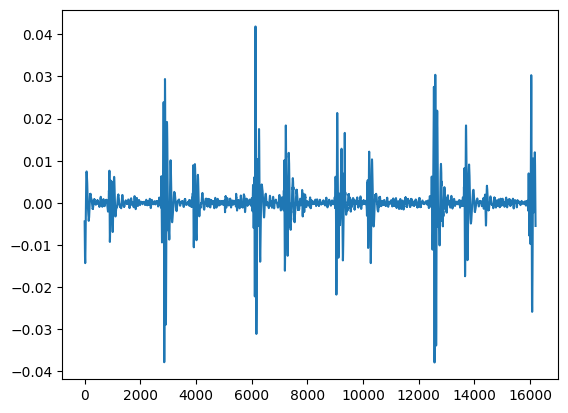

In [12]:
MIN_SECS = 3

filtered_segments = filter(lambda x: len(x) / sample_rate > MIN_SECS, segments)
valid_segments = list(map(lambda x: x.unsqueeze(0), filtered_segments))

for i, segment in enumerate(valid_segments):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()

# All wrapped in one function

#1 (3.5s): tensor([0.5866, 0.5866, 0.5869,  ..., 0.5203, 0.5147, 0.5094])


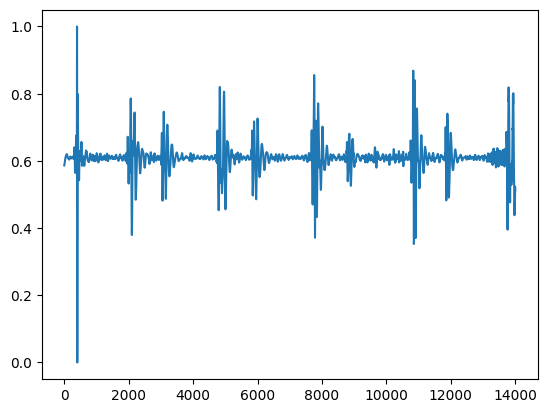

#2 (4.1s): tensor([0.4791, 0.4808, 0.4826,  ..., 0.4935, 0.4616, 0.4303])


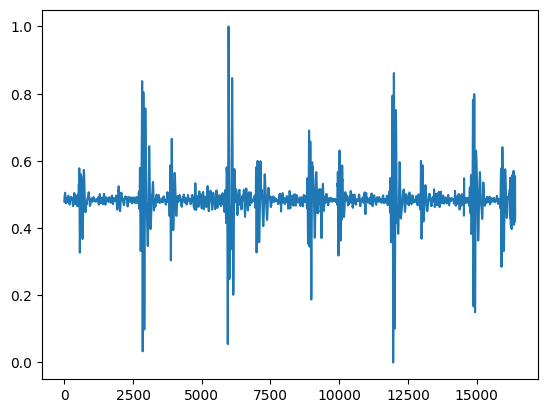

#3 (4.2s): tensor([0.5268, 0.5367, 0.5444,  ..., 0.5015, 0.4652, 0.4273])


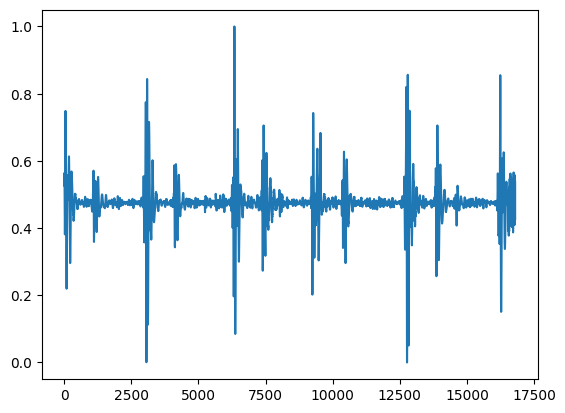

In [13]:
from helpers.transform import TrimAfterTrigger

tat = TrimAfterTrigger()

final_segments = tat.transform(
    audio_dir=DIGITAL_AUDIO_DIR,
    sample_rate_target=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    segment_min_duration=MIN_SECS,
)

for i, segment in enumerate(final_segments[0]):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()